To Do: 

- Verify that MSE is 0 for "correct input"
- Plot interactive 3D Plot with plotly (points should be close to mean surface)

In [2]:
import torch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition.analytic import LogExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.likelihoods import GaussianLikelihood
import gpytorch
import win32com.client
from botorch.models.transforms import Normalize
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.metrics import mean_absolute_error
torch.set_default_dtype(torch.float64)
from scipy.stats import qmc
import os
import subprocess
from pathlib import Path
import time
import pandas as pd
import plotly.graph_objects as go

c:\Users\oskay\miniforge3\envs\moldflow\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


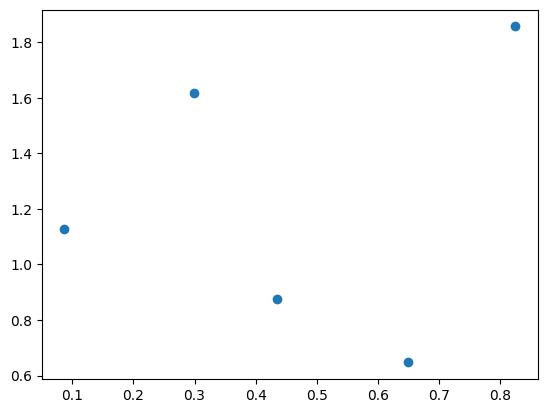

In [ ]:
# Generating inital values for Wall slip parameters

#tau_w_range = [0.001, 1] 
#m_range = [0.5, 2]

lower= [0.001, 0.5]
upper = [1.0, 2.0]

sampler = qmc.LatinHypercube(d=2)
sample = sampler.random(5)

scaled_values = qmc.scale(sample, lower, upper)
tau_w_values = scaled_values[:,0]
m_values = scaled_values[:,1]
plt.scatter(tau_w_values, m_values)
plt.show()

LHS_data = pd.DataFrame({
    'tau_w_values': tau_w_values,
    'm_values': m_values
})
#LHS_data.to_csv('tau_w_and_m_values.csv', index=False)

In [3]:
def calculate_area_between_curves(real_time, real_disp, guess_time, guess_disp):
    common_time = np.linspace(0.0, max(real_time.max(), guess_time.max()), num=200)

    # Resample both curves on this time grid
    real_disp_resampled = np.interp(common_time, real_time, real_disp)
    guess_disp_resampled = np.interp(common_time, guess_time, guess_disp)

    mse = np.mean((real_disp_resampled-guess_disp_resampled)**2)
    
    return mse
    # guess_disp_interpolated = np.interp(real_time, guess_time, guess_disp)
    # diff_disp = np.abs(real_disp - guess_disp_interpolated)
    # area = np.trapezoid(diff_disp, real_time)
    # return area
            
file_directory = Path("H:\\XMLFiles")
real_data_directory = "H:\\Real_data\\press_displacement_real.xml"
areas = []
area_data = []

real_tree = ET.parse(real_data_directory)
real_root = real_tree.getroot()
real_data = []
guess_data_all = {}

for time_block, dept_block in zip(real_root.findall('.//Block//IndpVar'), real_root.findall('.//Block')):
    time_value = time_block.attrib.get('Value')
    dept_value = dept_block.find('DeptValues').text.strip()
    real_data.append((time_value, dept_value))

real_data_array = np.array([(float(x), float(y)) for x, y in real_data])
real_time = real_data_array[:, 0]  
real_disp = real_data_array[:, 1]  




In [16]:
Synergy = win32com.client.Dispatch("synergy.Synergy")
Synergy.SetUnits("Metric")
moldflow = "C:\\Program Files\\Autodesk\\Moldflow Insight 2023\\bin"


Synergy.OpenProject("H:\\Moldflow_Projects\\wall_slip\\wall_slip.mpi")
Project = Synergy.Project
Project.OpenItemByName("60SurfaceCoverage_study", "Study")

# Simulation loop for wall slip parameters
for i in range(5):
    tau_w = tau_w_values[i]
    m = m_values[i]
    print(f"Simulation {i+1} with tau_w : {tau_w} and m: {m}")

    study_name =f"study_{i+1}"
    Project = Synergy.Project
    
    PropEd = Synergy.PropertyEditor
    Prop = PropEd.FindProperty(10090, 1)
    DVec = Synergy.CreateDoubleArray
    
    DVec.AddDouble(tau_w)
    DVec.AddDouble(m)
    DVec.AddDouble(1e-08)
    DVec.AddDouble(0)
    DVec.AddDouble(0)
    
    Prop.FieldValues(51182, DVec)
          
    PropEd.CommitChanges("Process Conditions")

    StudyDoc = Synergy.StudyDoc
    StudyDoc.SaveAs(study_name)

    p = subprocess.Popen(
    [os.path.join(moldflow, "runstudy.exe"), f"H:\\Moldflow_Projects\\wall_slip\\study_{i+1}.sdy"],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    )
    (output, err) = p.communicate()
    

    time.sleep(10)
    
    # Restart of the Synergy to prevent XML saving crash
    
    subprocess.run(["taskkill", "/f", "/im", "airsyn_synergy.exe"]) 

    time.sleep(10)

    Synergy.OpenProject("H:\\Moldflow_Projects\\wall_slip\\wall_slip.mpi")
    Project = Synergy.Project
    Project.OpenItemByName(f"study_{i+1}", "Study")


    PlotMgr = Synergy.PlotManager
    time.sleep(10)
    Plot = PlotMgr.FindPlotByName2("Press displacement:XY Plot", "Press displacement")
    Pid = Plot.GetDataID
    PlotMgr = None
    PlotMgr = Synergy.PlotManager
    time.sleep(10)
    PlotMgr.SaveResultDataInXML2( Pid, f"H:\\XMLFiles\\study_{i + 1}.xml", "Metric")
    
    


    
# Write the output to a log file
    with open(f"H:\\Log_Files\\study_{i+1}.log", "w") as file:
        file.write(output.decode("windows-1252").strip())

Simulation 1 with tau_w : 0.2985276696133687 and m: 1.6173063654861628
Simulation 2 with tau_w : 0.43421122417120145 and m: 0.8760155010286972
Simulation 3 with tau_w : 0.8244718074660233 and m: 1.8574093360484358
Simulation 4 with tau_w : 0.6488649837264557 and m: 0.6470387294434539
Simulation 5 with tau_w : 0.08723009231375611 and m: 1.1295515410866206


In [4]:

for i in range(5):
        guess_tree = ET.parse(f"H:\\XMLFiles\\study_{i + 1}.xml")
        guess_root = guess_tree.getroot()
        guess_data = []
                
        for time_block, dept_block in zip(guess_root.findall('.//Block//IndpVar'), guess_root.findall('.//Block')):
                time_value = time_block.attrib.get('Value')
                dept_value = dept_block.find('DeptValues').text.strip()
                guess_data.append((time_value, dept_value))

        guess_data_all[f"guess_data_{i+1}"] = guess_data

        guess_data_array = np.array([(float(x), float(y)) for x, y in guess_data])
        guess_time = guess_data_array[:, 0]  
        guess_disp = guess_data_array[:, 1]  
    
    
        mean_s_error = calculate_area_between_curves(real_time, real_disp, guess_time, guess_disp)
        area_data.append(mean_s_error)
print(guess_data_all)

{'guess_data_1': [('0.019225', '9.6125e-03'), ('0.152085', '7.6043e-02'), ('0.423948', '2.1197e-01'), ('0.678484', '3.3924e-01'), ('0.860615', '4.3031e-01'), ('1.072682', '5.3634e-01'), ('1.280738', '6.4037e-01'), ('1.425335', '7.1267e-01'), ('1.575704', '7.8785e-01'), ('1.747935', '8.7397e-01'), ('1.869918', '9.3496e-01'), ('2.029963', '1.0150e+00'), ('2.164583', '1.0823e+00'), ('2.287358', '1.1437e+00'), ('2.406723', '1.2034e+00'), ('2.606132', '1.3031e+00'), ('2.799133', '1.3996e+00'), ('2.927876', '1.4639e+00'), ('3.040890', '1.5204e+00'), ('3.157604', '1.5788e+00'), ('3.267260', '1.6336e+00'), ('3.370826', '1.6854e+00'), ('3.475550', '1.7378e+00'), ('3.577435', '1.7887e+00'), ('3.677085', '1.8385e+00'), ('3.725596', '1.8628e+00'), ('3.736025', '1.8682e+00'), ('3.742525', '1.8652e+00'), ('3.746025', '1.8656e+00'), ('3.747025', '1.8657e+00'), ('3.749025', '1.8659e+00'), ('3.753025', '1.8662e+00'), ('3.761025', '1.8668e+00'), ('3.777025', '1.8677e+00'), ('3.809025', '1.8689e+00'), ('

In [5]:
print(area_data)
print(list(guess_data_all.keys()))
for name, lst in guess_data_all.items():
    array = np.array(lst)
    print(f"{name}: Shape = {array.shape}")

[np.float64(3.188191019667877), np.float64(3.1852614824813124), np.float64(3.1729122166591), np.float64(3.1557571067384913), np.float64(3.201746182348975)]
['guess_data_1', 'guess_data_2', 'guess_data_3', 'guess_data_4', 'guess_data_5']
guess_data_1: Shape = (55, 2)
guess_data_2: Shape = (55, 2)
guess_data_3: Shape = (57, 2)
guess_data_4: Shape = (56, 2)
guess_data_5: Shape = (55, 2)


In [14]:
file_path = 'H:\\moldflow\\moldflow_automation\\tau_w_and_m_values.csv'  
data = pd.read_csv(file_path)
tau_w_values = data['tau_w_values'].values
m_values = data['m_values'].values
area_data_optimization = []
train_x = torch.tensor([[tau_w_values[0], m_values[0]], [tau_w_values[1], m_values[1]], [tau_w_values[2], m_values[2]], [tau_w_values[3], m_values[3]], [tau_w_values[4], m_values[4]]])
print(train_x)
train_y = torch.tensor([[area_data[0]], [area_data[1]], [area_data[2]], [area_data[3]], [area_data[4]]])
train_yvar = torch.full_like(train_y, 1e-8)
bounds = torch.tensor([
    [0.001, 1.0],
    [0.5, 2.0]
], dtype=torch.float64
)

outcome_transform = Standardize(m=1)
input_transform = Normalize(d=2)

# Optimization
model = SingleTaskGP(train_x, train_y,train_Yvar=train_yvar, outcome_transform=outcome_transform, input_transform=input_transform)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll)
model.eval()    

acq_func = LogExpectedImprovement(model, best_f=train_y.min(), maximize=False)

candidate, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=1,
        num_restarts=20,
        raw_samples=25,
)

cand = model(input_transform(candidate))
cand_var = torch.diagonal(cand.covariance_matrix, 0)
cand_mean, cand_std = outcome_transform.untransform(cand.mean, cand_var)

tensor([[0.2985, 1.6173],
        [0.4342, 0.8760],
        [0.8245, 1.8574],
        [0.6489, 0.6470],
        [0.0872, 1.1296]])


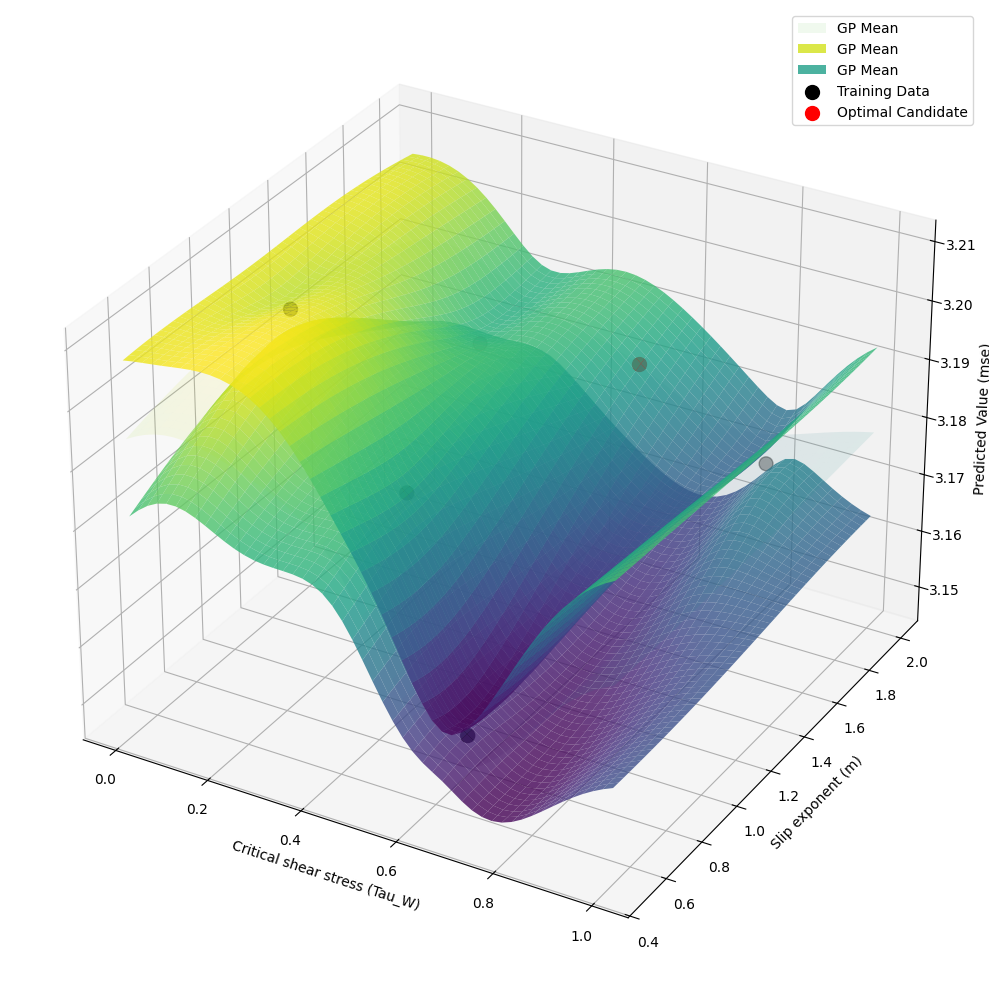

In [10]:
with torch.no_grad():
    # Generate grid for plotting
    x_grid, y_grid = np.meshgrid(
        np.linspace(bounds[0, 0].item(), bounds[0, 1].item(), 50),
        np.linspace(bounds[1, 0].item(), bounds[1, 1].item(), 50),
    )
    val_X_grid_tensor = torch.tensor(
        np.column_stack((x_grid.ravel(), y_grid.ravel())),
        dtype=torch.float64,
    )
    #plt.scatter(x_grid, y_grid)
    #plt.show()
    val_X_grid_tensor = input_transform(val_X_grid_tensor)

    # GP predictions on the grid
    pred_Y = model(val_X_grid_tensor)
    pred_Yvar = torch.diagonal(pred_Y.covariance_matrix, 0)
    pred_mean, pred_var = outcome_transform.untransform(pred_Y.mean, pred_Yvar)
    #pred_mean = pred_Y.mean
    #pred_var = pred_Yvar
    pred_mean = pred_mean.detach().numpy().reshape(x_grid.shape)
    pred_std = torch.sqrt(pred_var).detach().numpy().reshape(x_grid.shape)

    # Create 3D Plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(
        x_grid, y_grid, pred_mean, cmap="viridis", alpha=0.1, label="GP Mean"
    )
    ax.plot_surface(
        x_grid, y_grid, pred_mean+pred_std, cmap="viridis", alpha=0.8, label="GP Mean"
    )
    ax.plot_surface(
        x_grid, y_grid, pred_mean-pred_std, cmap="viridis", alpha=0.8, label="GP Mean"
    )
    ax.scatter(
        train_x[:, 0].numpy(), train_x[:, 1].numpy(), train_y.flatten().numpy(), 
        color="black", s=100, label="Training Data"
    )
    ax.scatter(
        candidate[0, 0],
        candidate[0, 1],
        cand_mean.item(),
        color="red",
        s=100,
        label="Optimal Candidate",
    )
    ax.set_xlabel("Critical shear stress (Tau_W)")
    ax.set_ylabel("Slip exponent (m)")
    ax.set_zlabel("Predicted Value (mse)")
    ax.legend()
    plt.tight_layout()
    plt.show()


In [15]:

# Generate grid for plotting 
x_flat = x_grid.ravel()
y_flat = y_grid.ravel()

# Convert pred_mean and pred_std to flat arrays for plotting
pred_mean_flat = pred_mean.ravel()
pred_std_flat = pred_std.ravel()

# Initialize Plotly figure
fig = go.Figure()

# Add the mean surface
fig.add_trace(go.Surface(
    x=x_grid, y=y_grid, z=pred_mean,
    colorscale='Viridis', opacity=0.6, name="GP Mean"
))

# Add upper uncertainty surface (mean + std)
fig.add_trace(go.Surface(
    x=x_grid, y=y_grid, z=pred_mean + pred_std,
    colorscale='Viridis', opacity=0.3, showscale=False, name="GP Mean + Std"
))

# Add lower uncertainty surface (mean - std)
fig.add_trace(go.Surface(
    x=x_grid, y=y_grid, z=pred_mean - pred_std,
    colorscale='Viridis', opacity=0.3, showscale=False, name="GP Mean - Std"
))

# Add training points
fig.add_trace(go.Scatter3d(
    x=train_x[:, 0].numpy(),
    y=train_x[:, 1].numpy(),
    z=train_y.flatten().numpy(),
    mode='markers',
    marker=dict(size=8, color='black'),
    name='Training Data'
))

# Add optimal candidate
fig.add_trace(go.Scatter3d(
    x=[candidate[0, 0].item()],
    y=[candidate[0, 1].item()],
    z=[cand_mean.item()],
    mode='markers',
    marker=dict(size=8, color='red', symbol='circle'),
    name='Optimal Candidate'
))

# Update layout
fig.update_layout(
    scene=dict(
        xaxis_title="Critical shear stress (Tau_W)",
        yaxis_title="Slip exponent (m)",
        zaxis_title="Predicted Value (mse)"
    ),
    title="Interactive GP Model Predictions with Uncertainty",
    margin=dict(l=0, r=0, b=0, t=40)
)

# Show the plot
fig.show()
fig.write_html("gp_model_predictions.html")

In [91]:
area_data_optimization = []
train_x = torch.tensor([[tau_w_values[0], m_values[0]], [tau_w_values[1], m_values[1]], [tau_w_values[2], m_values[2]], [tau_w_values[3], m_values[3]], [tau_w_values[4], m_values[4]]])
train_y = torch.tensor([[area_data[0]], [area_data[1]], [area_data[2]], [area_data[3]], [area_data[4]]])

bounds = torch.tensor([
    [0.001, 0.5],
    [1, 2]
], dtype=torch.float64
)

outcome_transform = Standardize(m=1)
input_transform = Normalize(d=2)

# Optimization

num_iteration = 100
#tolerance = 1e-12
previous_best_area = float('inf')

for i in range(num_iteration):
    model = SingleTaskGP(train_x, train_y, outcome_transform=outcome_transform, input_transform=input_transform)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    
    acq_func = LogExpectedImprovement(model, best_f=train_y.min(), maximize=False)

    candidate, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=1,
        num_restarts=20,
        raw_samples=25,
    )

    print(f"Iteration {i+1}: Suggested new parameters (tau_w, m)", candidate)

    study_name = f"optimization_{i+1}"
    Project = Synergy.Project
    
    PropEd = Synergy.PropertyEditor
    Prop = PropEd.FindProperty(10090, 1)
    DVec = Synergy.CreateDoubleArray
    
    DVec.AddDouble(candidate[0,0].item())
    DVec.AddDouble(candidate[0,1].item())
    DVec.AddDouble(1e-08)
    DVec.AddDouble(0)
    DVec.AddDouble(0)
    
    Prop.FieldValues(51182, DVec)
          
    PropEd.CommitChanges("Process Conditions")
    StudyDoc = Synergy.StudyDoc
    StudyDoc.SaveAs(study_name)
    
    p = subprocess.Popen(
    [os.path.join(moldflow, "runstudy.exe"), f"H:\\Moldflow_Projects\\wall_slip\\optimization_{i+1}.sdy"],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    )
    (output, err) = p.communicate()
    

    time.sleep(10)
    
    # Restart of the Synergy to prevent XML saving crash
    
    subprocess.run(["taskkill", "/f", "/im", "airsyn_synergy.exe"]) 

    time.sleep(10)

    Synergy.OpenProject("H:\\Moldflow_Projects\\wall_slip\\wall_slip.mpi")
    Project = Synergy.Project
    Project.OpenItemByName(f"optimization_{i+1}", "Study")
    PlotMgr = Synergy.PlotManager
    time.sleep(10)
    Plot = PlotMgr.FindPlotByName2("Press displacement:XY Plot", "Press displacement")
    Pid = Plot.GetDataID
    PlotMgr = None
    PlotMgr = Synergy.PlotManager
    time.sleep(10)
    PlotMgr.SaveResultDataInXML2( Pid, f"H:\\XMLFiles\\optimization_{i + 1}.xml", "Metric")
    
    for i in range(num_iteration):

        guess_tree = ET.parse(f"H:\\XMLFiles\\optimization_{i + 1}.xml")
        guess_root = guess_tree.getroot()
        guess_data = []
    
        for time_block, dept_block in zip(guess_root.findall('.//Block//IndpVar'), guess_root.findall('.//Block')):
            time_value = time_block.attrib.get('Value')
            dept_value = dept_block.find('DeptValues').text.strip()
            guess_data.append((time_value, dept_value))

        
        guess_data_array = np.array([(float(x), float(y)) for x, y in guess_data])
        guess_time = guess_data_array[:, 0]  
        guess_disp = guess_data_array[:, 1]  
    
    
        area = calculate_area_between_curves(real_time, real_disp, guess_time, guess_disp)
        area_data_optimization.append(area)
        print(area_data_optimization)

    
# Write the output to a log file
    with open(f"H:\\Log_Files\\optimization_{i+1}.log", "w") as file:
        file.write(output.decode("windows-1252").strip())

    train_x = torch.cat([train_x, candidate], dim=0)
    train_y = torch.cat([train_y, torch.tensor([[area]])], dim=0)

    current_best_area = train_y.min().item()

    if abs(current_best_area) < 0.1:
        print(f"Converged after {i+1} iteration")
        break

    

best_params = train_x[train_y.argmin()]
best_area = train_y.min().item()
print(f"Best parameters (tau_w, m): {best_params}, with area: {best_area}")

Iteration 1: Suggested new parameters (tau_w, m) tensor([[0.7435, 0.5137]])


NameError: name 'Synergy' is not defined

In [ ]:
common_time = np.linspace(0.0, max(real_time.max(), guess_time.max()), num=500)

# Resample both curves on this time grid
real_disp_resampled = np.interp(common_time, real_time, real_disp)
guess_disp_resampled = np.interp(common_time, guess_time, guess_disp)

mse = np.mean((real_disp_resampled-guess_disp_resampled)**2)



C:\Users\sozenosk\AppData\Local\Temp\ipykernel_28408\2719426955.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


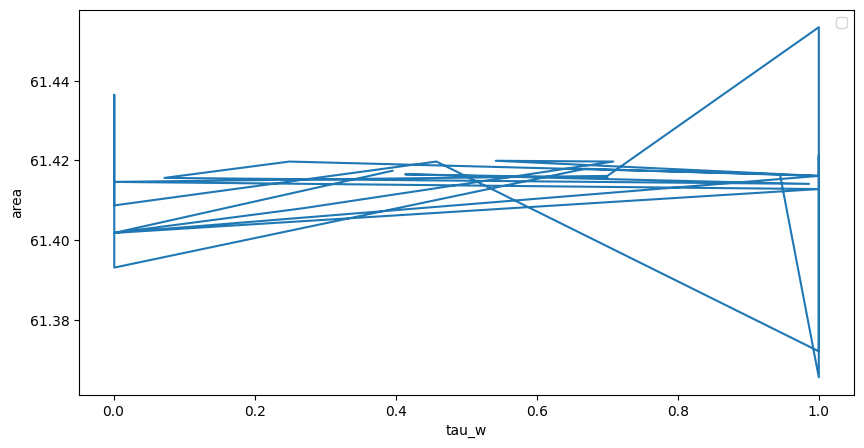

In [ ]:

x1, x2 = zip(*train_x)

plt.figure(figsize=(10, 5))
plt.plot(x1, train_y,)
# plt.plot(train_y, x2, label='m')

# Label the axes
plt.xlabel('tau_w')
plt.ylabel('area')
plt.legend()

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

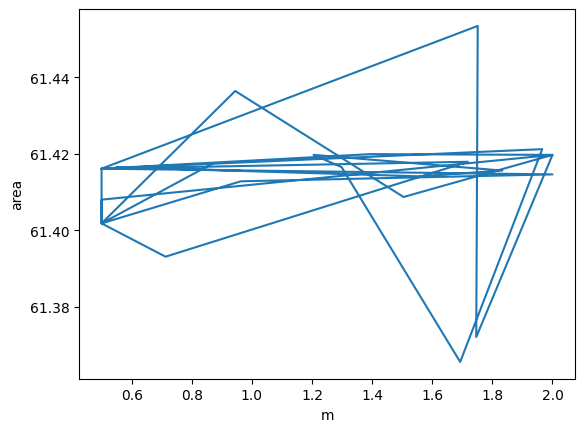

In [ ]:
plt.plot(x2, train_y, label='m')
plt.xlabel("m")
plt.ylabel("area")
plt.show

In [ ]:
guess_time.shape

(1499,)